# Exp 016: Analyze Performance in Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import random

import sys
sys.path.append("../source")
import importlib
#importlib.reload(helpers)
from helpers import format_context, egp, get_prompt_task_2, get_preferred_nrs
from evaluation import calculate_distinct_n

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.57402226.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [2]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_constraints_neg': ['mean']} if 'num_constraints_neg' in results.columns else {}
    aggs = results.groupby(by).agg({'num_constraints_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in ['Appropriateness',
                                                                          'Relevance',
                                                                          'Content Richness',
                                                                          'Grammatical Correctness']}})
    return aggs

def plot_sat(res, col='num_constraints_sat', by='num_constraints', xlabel="Number of constraints", title="Relative amount of satisfied constraints"):
    get_aggs(res, ["model", by]).unstack(level=0)[col]['mean'].plot(kind='bar', rot=0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel("Success Rate")
    plt.xlabel(xlabel)
    plt.ylim(0,1)
    plt.title(title)
    plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        ax.annotate(txt, (x.iloc[i]+0.01, y.iloc[i]-0.02))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

# Task 1

In [3]:
models = ["gpt35", "llama", "llama-FT-multi", "llama-decoding"]#, "llama-FT-decoding"
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task1/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]
    results['responses0'] = results['responses'].apply(lambda x: x[0])
    results['num_constraints'] = results['constraints'].apply(len)
    results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
    res = pd.concat([res, results])

single_constraints = res[res['num_constraints']==1].copy()
single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])

## Qualitative evaluation

Pick a random test case and print answers from all models

In [162]:
case = res.loc[random.randint(0, max(res.index))]
print("=== DIALOG ===")
print(format_context(case.iloc[0]['context']))
constraints = case.iloc[0]['constraints']
print("=== CONSTRAINTS ===")
for statement in egp[egp['#'].isin(constraints)]['Can-do statement']:
    print(statement)
print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses0']} ({responses.iloc[0]['num_constraints_sat']:.1%})")

=== DIALOG ===
A: Have you got any experience in advertising?
B: Yes, I have been working in the Public Relations Section of a company in the past two years. I plan the advertising campaign and cooperate the work of artists and typographers. Sometimes I have to do the work of a specialist when there ' s something urgent.
A: Do you have any practical experience as a secretary?
B: Yes, sir. I acted as a secretary in an insurance company.
=== CONSTRAINTS ===
Can use question forms.
=== RESPONSES ===
Model: gpt35
A: Would you say that your experience as a secretary has helped you develop skills that are transferable to the advertising industry? (100.0%)
Model: llama
Would you say that your experience in advertising has helped you develop strong organizational skills? (100.0%)
Model: llama-FT-multi
Would you mind telling me why you left your last job? (100.0%)
Model: llama-decoding
Would you say that your experience in advertising has helped you develop strong organizational skills? (100.0%

## Quantitative Evaluation

In [163]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness        \
                                           mean count            mean count   
model          response_hit                                                   
gpt35          0.0                     0.507586   725        3.658703   586   
               1.0                     0.612414   725        3.696095   589   
llama          0.0                     0.606897   725        3.312849   179   
               1.0                     0.615172   725        3.279793   193   
llama-FT-multi 0.0                     0.659310   725        2.705556   180   
               1.0                     0.758621   725        2.818182   187   
llama-decoding 0.0                     0.835862   725        3.098958   192   
               1.0                     0.823448   725        3.140625   192   

                            Relevance       Content Richness        \
                                 mean count             mean count   
model          response_hit                                          
gpt35          0.0           3.452218   586         3.083618   586   
               1.0           3.528014   589         3.168081   589   
llama          0.0           2.972067   179         2.893855   179   
               1.0           2.994819   193         2.860104   193   
llama-FT-multi 0.0           2.372222   180         2.333333   180   
               1.0           2.411765   187         2.374332   187   
llama-decoding 0.0           2.713542   192         2.744792   192   
               1.0           2.755208   192         2.807292   192   

                            Grammatical Correctness        
                                               mean count  
model          response_hit                                
gpt35          0.0                         4.953925   586  
               1.0                         4.955857   589  
llama          0.0                         4.932961   179  
               1.0                         4.932642   193  
llama-FT-multi 0.0                         4.644444   180  
               1.0                         4.673797   187  
llama-decoding 0.0                         4.838542   192  
               1.0                         4.828125   192

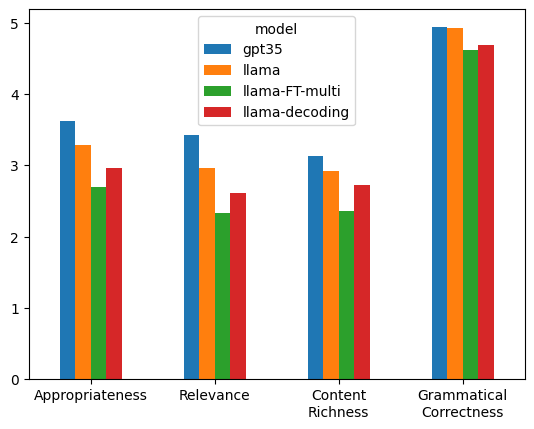

In [164]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

In [165]:
def get_mean_distinct(model):
    return get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True)['responses0']['calculate_distinct_n'].mean()
print()

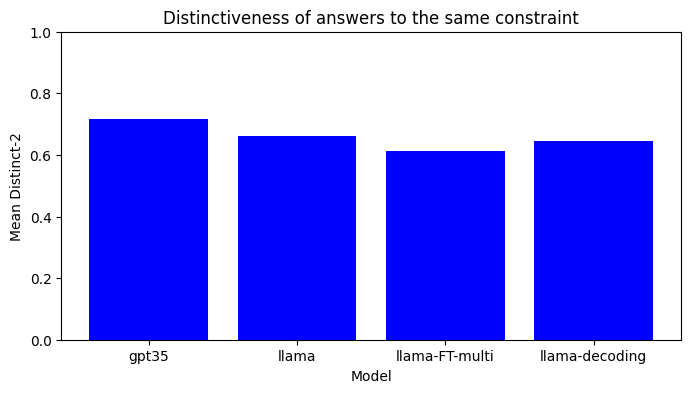

In [166]:
plt.figure(figsize=(8, 4))
plt.bar(models, [get_mean_distinct(model) for model in models], color='blue')
plt.xlabel('Model')
plt.ylabel('Mean Distinct-2')
plt.ylim(0,1)
plt.title('Distinctiveness of answers to the same constraint')
plt.show()

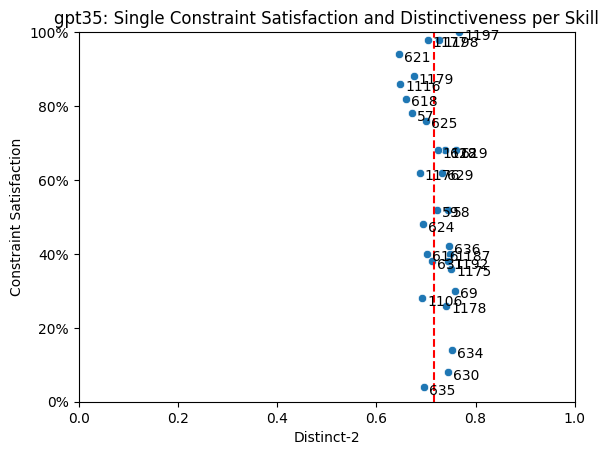

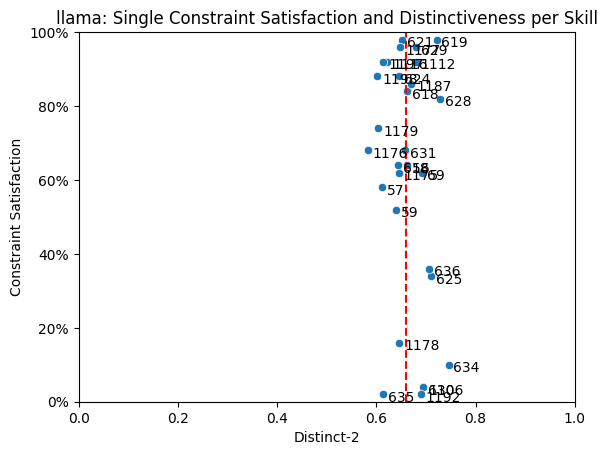

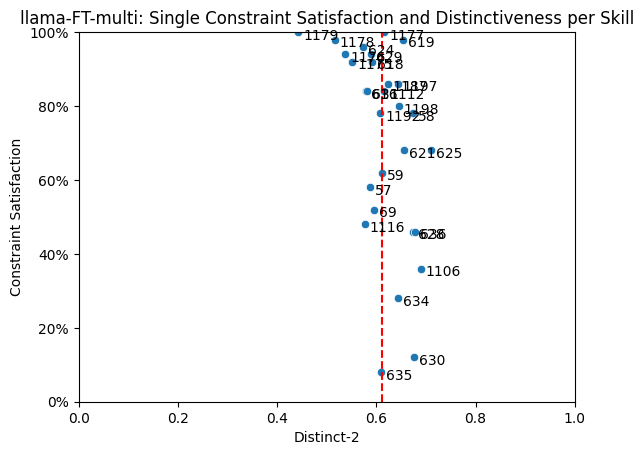

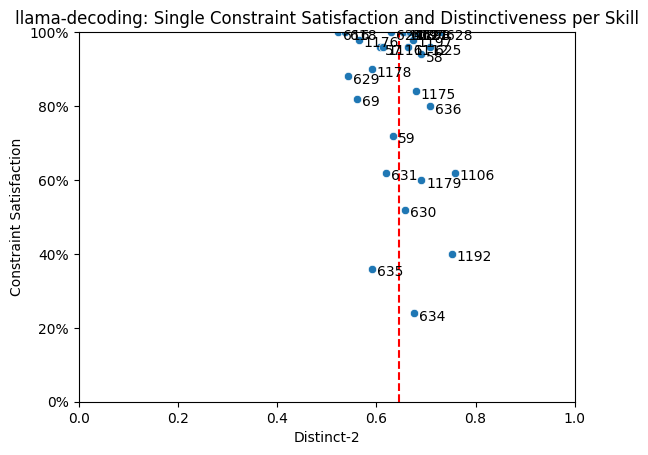

In [167]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

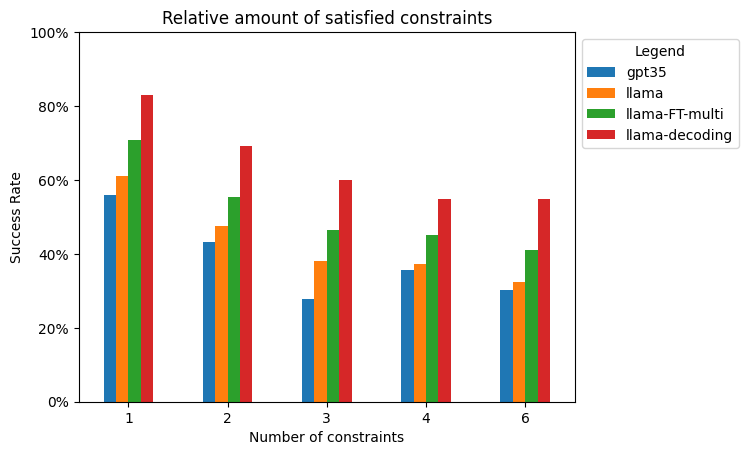

In [4]:
plot_sat(res)

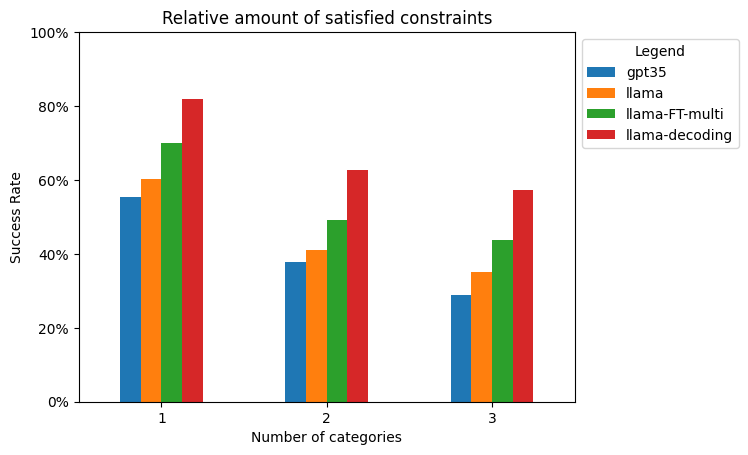

In [169]:
plot_sat(res, by="n_subcats", xlabel="Number of categories")

# Task 2

In [5]:
def categories_satisfied(row, type='positive'):
    df = pd.DataFrame({'score': row[f'{type}_constraints'], 'category': row[f'{type}_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)>0})['score'])

In [20]:
models = ["gpt35", "llama", "llama-FT-task1", "llama-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task2/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['num_constraints'] = results['categories'].apply(len)
    results['num_constraints_sat'] = results.apply(categories_satisfied, axis=1)
    results['num_constraints_neg'] = results.apply(categories_satisfied, axis=1, args=['negative'])
    res = pd.concat([res, results])

## Qualitative Evaluation

In [26]:
case = res.loc[random.randint(0, max(res.index))]
msg = get_prompt_task_2(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['num_constraints_sat']:.0%}/{responses.iloc[0]['num_constraints_neg']:.0%})")

Given the dialog, write a possible next turn of A that preferably use the following grammar patterns in the response:
- negation on CEFR level B2 (FORM/USE: 'NOT', EMPHASIS)
- superlatives on CEFR level A1 (FORM: 'MY BEST FRIEND')
Dialog:
A: Oh that is interesting. Did you know there are twin White House buildings in Ireland and France?
B: I had no idea.  I wonder why?  Teddy Roosevelt was a staunch conservationist and banned Christmas trees for the white house.
A: Wow that doesn't seem very fun. George Bush had solar panels put back on the White House luckily. The more energy you can save the better!
B: I agree!  I was surprised to find out that the white house was shot at on Nov. 11, 2011 and it took the secret service 4 days to realize it.  Scary!

=== RESPONSES ===
Model: gpt35
A: That's not very reassuring. It's important for the White House to have top-notch security measures in place. My best friend told me that the White House is one of the most heavily guarded buildings in the

## Quantitative evaluation

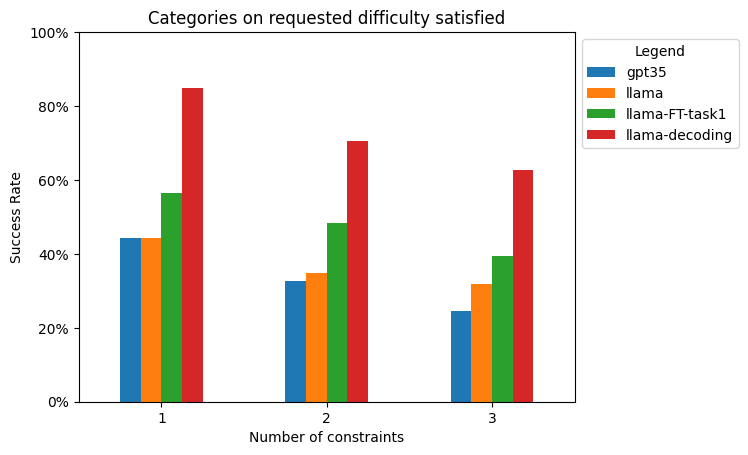

In [22]:
plot_sat(res, title="Categories on requested difficulty satisfied")

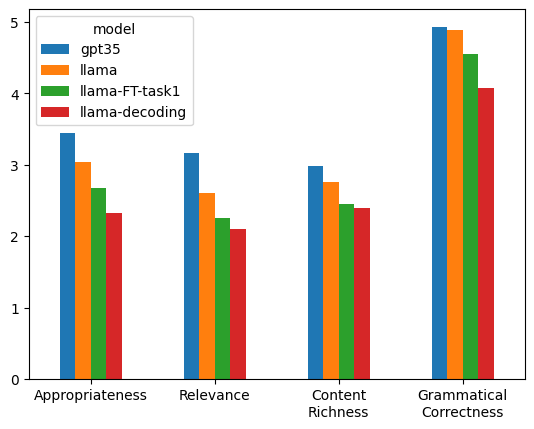

In [23]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

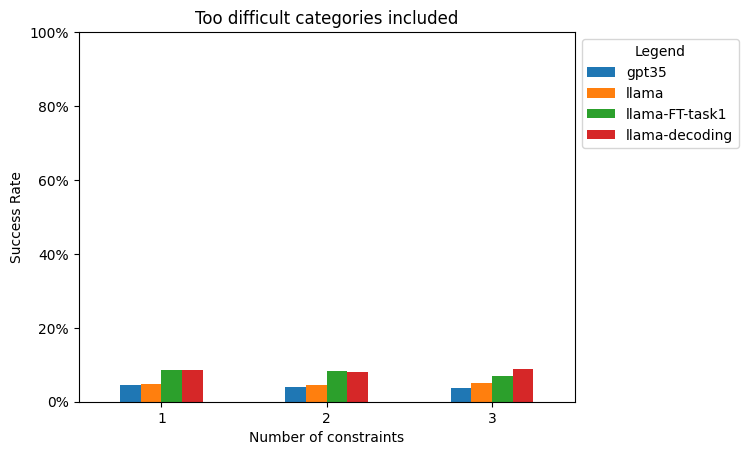

In [24]:
plot_sat(res, 'num_constraints_neg', title="Too difficult categories included")